No fiber


d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


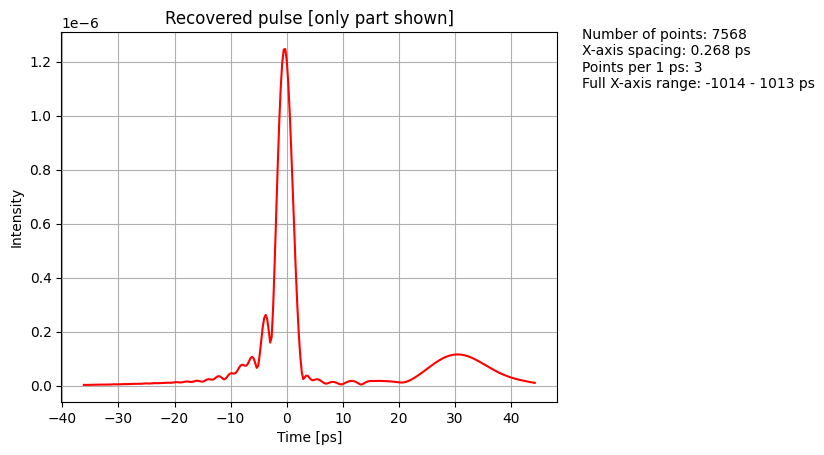

With fiber


d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


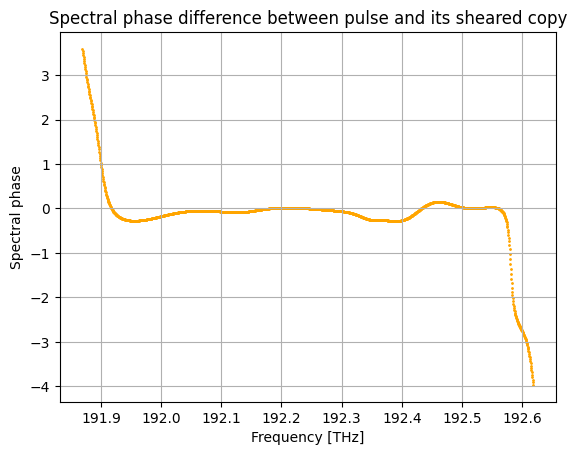

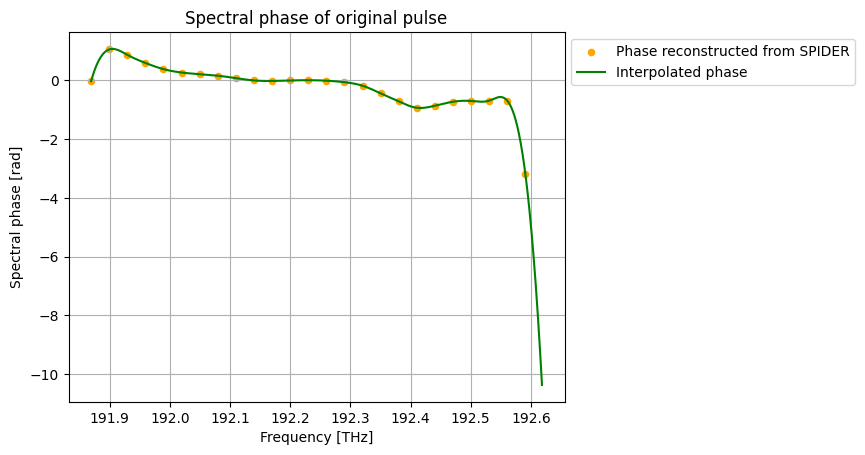

d:\Users\rewas\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


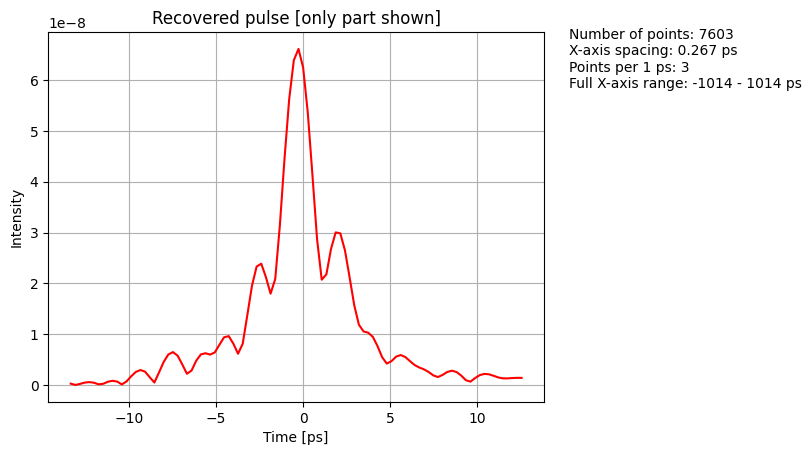

In [1]:
# modules

import spectral_analysis as sa
import pandas as pd

# find shears

not_sheared_1 = pd.read_csv("dane\pure_noshear_nofiber.csv", skiprows = 2)
sheared_1 = pd.read_csv("dane\pure_smallshear_nofiber.csv", skiprows = 2)
not_sheared_2 = pd.read_csv("dane\pure_noshear_fiber.csv", skiprows = 2)
sheared_2 = pd.read_csv("dane\pure_smallshear_fiber.csv", skiprows = 2)

shear_1 = sa.find_shear(sheared_1, not_sheared_1, "convert_to_freq")
shear_2 = sa.find_shear(sheared_2, not_sheared_2, "convert_to_freq")

# and execute spider

print("No fiber")
sa.spider("dane\int_smallshear_nofiber.csv", shear = shear_1, left_cut = 17, right_cut = 40, plot = False, phase_plot = False)
#sa.spider("dane\int_smallshear_nofiber.csv", intensity_spectrum = "dane\pure_noshear_nofiber.csv", shear = shear_1, left_cut = 17, right_cut = 40, plot = False, phase_plot = True)

print("With fiber")
sa.spider("dane\int_smallshear_fiber.csv", shear = shear_2, left_cut = 17, right_cut = 40, plot = False, phase_plot = True)
#sa.spider("dane\int_smallshear_fiber.csv", intensity_spectrum = "dane\pure_noshear_fiber.csv", shear = shear_2, left_cut = 17, right_cut = 40, plot = True, phase_plot = True)

# Ok, let's do it by hand to remove the temporal phase

In [2]:
# modules

import pandas as pd
import numpy as np
from math import floor as flr
import spectral_analysis as sa
import matplotlib.pyplot as plt

# meta

shear = shear = sa.find_shear(sheared_1, not_sheared_1, "convert_to_freq")
plot = False
phase_plot = False
left_cut = 17
right_cut = 40
intensity_spectrum = "dane\pure_noshear_fiber.csv"
spider_spectrum = "dane\int_smallshear_fiber.csv"

# load data

spectrum = pd.read_csv(spider_spectrum, skiprows = 2)
spectrum = sa.zero_padding(spectrum, 1)
min = sa.quantile(spectrum, 0.01)
max = sa.quantile(spectrum, 0.99)
delta = (max-min)/10
min_wl = min-delta
max_wl = max+delta 
if plot:
    sa.plot(spectrum, "orange", title = "Data from OSA", min = min_wl, max = max_wl, type = "wl")

# transform X-axis to frequency

s_freq = sa.wl_to_freq(spectrum)
s_freq = sa.constant_spacing(s_freq)
min = sa.quantile(s_freq, 0.01)
max = sa.quantile(s_freq, 0.99) 
delta = (max-min)/10
min_freq = min-delta
max_freq = max+delta
if plot: sa.plot(s_freq,"orange", title = "Wavelength to frequency", type = "freq", min = min_freq, max = max_freq)

integrate_interval = flr(shear/(np.mean(np.diff(s_freq.values[:, 0]))))
mean = np.mean(s_freq.values[:, 0])

# fourier transform

s_ft = sa.fourier(s_freq, absolute = False)
min = sa.quantile(s_ft, 0.1)
max = sa.quantile(s_ft, 0.9)
delta = (max-min)/3
min_time = min-delta
max_time = max+delta
if plot: sa.plot(s_ft, title ="Fourier transformed", type = "time", min = min_time, max = max_time)

# filter one peak

s_ft = sa.replace_with_zeros(s_ft, start = "min", end = left_cut)
s_ft = sa.replace_with_zeros(s_ft, start = right_cut, end = "max")
if plot: sa.plot(s_ft, title = "Filtered", type = "time", min = min-delta, max = max+delta)

# shift to zero

s_shift = sa.smart_shift(s_ft, shift = "center")
support = right_cut-left_cut
if plot: sa.plot(s_shift, title = "Shifted", type = "time", min = -1.5*support, max = 1.5*support)

# inverse fourier

s_ift = sa.inv_fourier(s_shift)
if plot:
    s_ift2 = s_ift.copy()
    s_ift2.values[:, 0] += mean 
    sa.plot(s_ift2, title = "Inverse Fourier transformed", type = "freq", min = min_freq, max = max_freq)

# phase extraction

min_phase = sa.quantile(s_ift, 0.025)
max_phase = sa.quantile(s_ift, 0.975)

s_cut = sa.cut(s_ift, start = min_phase, end = max_phase)

values = s_cut.values[:, 1].copy()
X = s_cut.values[:, 0].copy()

values = np.angle(values)
values = np.unwrap(values)

# prepare data to plot

X = X + mean
X2 = X.copy()

# plot phase difference

if False:

    plt.scatter(X, np.real(values), color = "orange", s = 1)
    plt.title("Spectral phase difference between pulse and its sheared copy")
    plt.xlabel("Frequency [THz]")
    plt.ylabel("Spectral phase")
    plt.grid()
    plt.show()

# and plot phase

X = X[::integrate_interval]
values = values[::integrate_interval]

phase_frame = pd.DataFrame(np.transpose(np.stack((X, np.cumsum(values)))))
interpolated_phase = sa.interpolate(phase_frame, X2)

from ipywidgets import interact, FloatSlider

def phase_slider(tau):

    Y = np.cumsum(values) + tau*X
    Y -= Y[flr(len(Y)/2)]
    plt.scatter(X, Y, color = "orange", s = 20)
    #plt.plot(interpolated_phase.values[:,0], interpolated_phase.values[:,1], color = "green")
    plt.title("Spectral phase of original pulse")
    #plt.legend(["Phase reconstructed from SPIDER"], bbox_to_anchor = [1, 1])
    plt.xlabel("Frequency [THz]")
    plt.ylabel("Spectral phase [rad]")
    plt.ylim(bottom = Y[flr(len(Y)/2)] - np.std(Y)/2, top = Y[flr(len(Y)/2)] + np.std(Y)/2)
    plt.grid()

if False: # no fiber
    min = 250.
    max = 300.
    step = 0.2
    value = 275.

else: # fiber
    min = 70.
    max = 130.
    step = 0.2
    value = 110.

interact(phase_slider, tau = FloatSlider(min = min, max = max, step = step, value = value));


interactive(children=(FloatSlider(value=110.0, description='tau', max=130.0, min=70.0, step=0.2), Output()), _…